Using device: cuda
Starting data loading...
Total data points loaded: 3367075
Created 3366 sequences with length 1000.
Reverted Classifier DataLoaders to standard TensorDataset (no augmentation).
Loading pre-trained Autoencoder from best_dilated_ae_A.pth

--- Part 5: Classifier with Transformer Head & Custom Loss ---
Loaded best dilated encoder from best_dilated_encoder_A.pth for classifier.

Starting Classifier training (Transformer Head, Custom Loss, Augmentation)...

--- Fine-tuning Phase 1 (Custom Loss & Aug): Training Classifier Head Only ---
CLF P1 Custom Epoch 1/200 - 0.97s - Train Acc: 0.2530 - Val Acc: 0.3010 - LR: 1.0e-03
  New best P1 Custom model saved with val_acc: 0.3010
CLF P1 Custom Epoch 2/200 - 1.10s - Train Acc: 0.2810 - Val Acc: 0.3525 - LR: 1.0e-03
  New best P1 Custom model saved with val_acc: 0.3525
CLF P1 Custom Epoch 3/200 - 0.78s - Train Acc: 0.2810 - Val Acc: 0.2653 - LR: 1.0e-03
CLF P1 Custom Epoch 4/200 - 0.83s - Train Acc: 0.3001 - Val Acc: 0.2495 - LR: 1.

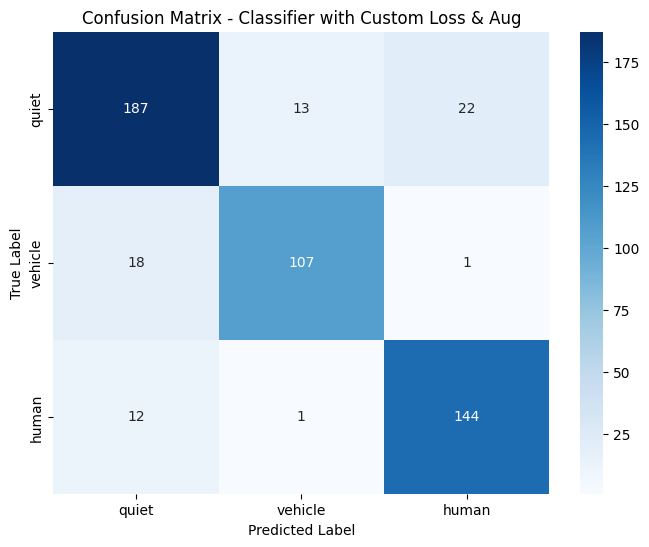


--- PyTorch Pipeline with Custom Loss & Augmentation Completed ---


In [8]:
# Part 0: Setup and Global Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset # Added Dataset for augmentation
import torch.nn.functional as F # For custom loss
import glob
import os
import time
import random # For augmentation decisions

# For reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED) # For Python's random module
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Define global constants based on recommendations ---
DATA_PATH = "data/"
SEQUENCE_LENGTH = 1000
ENCODING_DIM_AE = 64
AE_TRAIN_EPOCHS_FINAL = 60 # Re-using the epoch where previous AE stopped
AE_PATIENCE_FINAL = 15 # Slightly reduced patience for AE if re-training
CLASSIFIER_TRAIN_EPOCHS = 100
CLASSIFIER_BATCH_SIZE = 32
AE_BATCH_SIZE = 32

FT_PHASE1_EPOCHS = 200
FT_PHASE2_EPOCHS = 200
FT_PHASE3_EPOCHS = 200
FT_PATIENCE = 20

# Custom Loss parameters (can be tuned)
CUSTOM_LOSS_ALPHA = 0.25 # Typical Focal Loss alpha
CUSTOM_LOSS_GAMMA = 2.0
QUIET_HUMAN_WEIGHT = 1.0 # Penalty for quiet-human confusion

# Augmentation parameters (can be tuned)
AUG_NOISE_LEVEL_QUIET = 0.005 # Reduced from 0.01 to be more subtle
AUG_MASK_RATIO_QUIET = 0.05  # Reduced from 0.1
AUG_AMP_SCALE_HUMAN_MIN = 0.85 # Slightly tighter range
AUG_AMP_SCALE_HUMAN_MAX = 1.15
AUG_TIME_WARP_FACTOR_HUMAN = 0.05 # Reduced from 0.1
AUG_PROBABILITY = 0.5 # Probability of applying augmentation to a sample

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Part 1: Data Loading and Preparation ---
# (load_and_prepare_data and create_sequences functions are assumed to be the same)
def load_and_prepare_data(data_path_folder):
    file_mapping = {
        'car_nothing(AVI).csv': 'quiet',
        'carnew(AVI).csv': 'vehicle',
        'human_nothing(AVI).csv': 'quiet',
        'human(AVI).csv': 'human'
    }
    label_encoding = {'quiet': 0, 'vehicle': 1, 'human': 2}
    all_data = []
    all_labels = []
    print("Starting data loading...")
    if not os.path.exists(data_path_folder):
        print(f"Data folder {data_path_folder} not found. Please create it and add data files.")
        return np.array([]), np.array([])
    for filename, activity_type in file_mapping.items():
        filepath = os.path.join(data_path_folder, filename)
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}. Skipping.")
            continue
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty and df.shape[1] > 0:
                data = df.iloc[:, 0].values
                label_code = label_encoding[activity_type]
                all_data.extend(data)
                all_labels.extend([label_code] * len(data))
            else:
                print(f"Warning: File {filename} is empty or has no data columns. Skipping.")
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    all_data_np = np.array(all_data)
    all_labels_np = np.array(all_labels)
    if len(all_data_np) > 0:
        print(f"Total data points loaded: {len(all_data_np)}")
    else:
        print("No data was loaded.")
    return all_data_np, all_labels_np

X_raw, y_raw = load_and_prepare_data(DATA_PATH)
if len(X_raw) == 0: exit()

def create_sequences(data, labels, sequence_length):
    sequences, sequence_labels = [], []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_data = data[label_indices]
        num_sequences_for_label = len(label_data) // sequence_length
        for i in range(num_sequences_for_label):
            start_idx = i * sequence_length
            end_idx = start_idx + sequence_length
            sequences.append(label_data[start_idx:end_idx])
            sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

X_sequences, y_sequences = create_sequences(X_raw, y_raw, SEQUENCE_LENGTH)
if len(X_sequences) == 0: exit()
print(f"Created {len(X_sequences)} sequences with length {SEQUENCE_LENGTH}.")

X_train_seq, X_temp_seq, y_train_labels, y_temp_labels = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=SEED, stratify=y_sequences
)
X_val_seq, X_test_seq, y_val_labels, y_test_labels = train_test_split(
    X_temp_seq, y_temp_labels, test_size=0.5, random_state=SEED, stratify=y_temp_labels
)

scaler = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, 1); scaler.fit(X_train_flat)
X_train_normalized = scaler.transform(X_train_flat).reshape(X_train_seq.shape)
X_val_normalized = scaler.transform(X_val_seq.reshape(-1, 1)).reshape(X_val_seq.shape)
X_test_normalized = scaler.transform(X_test_seq.reshape(-1, 1)).reshape(X_test_seq.shape)

# Keep original (non-reshaped for PyTorch Conv1D) for augmentation functions
X_train_aug = X_train_normalized.copy() # Will be used by AugmentedDataset
X_val_aug = X_val_normalized.copy() # For consistency, though val usually not augmented

# Reshape for PyTorch Conv1D input
X_train_reshaped = X_train_normalized[:, np.newaxis, :]
X_val_reshaped = X_val_normalized[:, np.newaxis, :]
X_test_reshaped = X_test_normalized[:, np.newaxis, :]

# Tensors for AE (uses non-augmented data for reconstruction)
X_train_tensor_ae = torch.tensor(X_train_reshaped, dtype=torch.float32)
X_val_tensor_ae = torch.tensor(X_val_reshaped, dtype=torch.float32)
y_train_tensor_ae = torch.tensor(y_train_labels, dtype=torch.long) # Not used by AE target, but good to have
y_val_tensor_ae = torch.tensor(y_val_labels, dtype=torch.long)

train_dataset_ae = TensorDataset(X_train_tensor_ae, X_train_tensor_ae)
val_dataset_ae = TensorDataset(X_val_tensor_ae, X_val_tensor_ae)
train_loader_ae = DataLoader(train_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader_ae = DataLoader(val_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

# Tensors for Classifier (will use AugmentedDataset for training)
X_test_tensor_clf = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor_clf = torch.tensor(y_test_labels, dtype=torch.long)


# --- Data Augmentation Functions (NEW) ---
def augment_gaussian_noise(signal, noise_level=AUG_NOISE_LEVEL_QUIET):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def augment_time_mask(signal, mask_ratio=AUG_MASK_RATIO_QUIET):
    signal_aug = signal.copy()
    mask_length = int(len(signal_aug) * mask_ratio)
    if mask_length > 0 and len(signal_aug) - mask_length > 0 :
        start_idx = random.randint(0, len(signal_aug) - mask_length -1)
        signal_aug[start_idx : start_idx + mask_length] = 0.0 # Mask with zeros
    return signal_aug

def augment_amplitude_scale(signal, scale_min=AUG_AMP_SCALE_HUMAN_MIN, scale_max=AUG_AMP_SCALE_HUMAN_MAX):
    scale = random.uniform(scale_min, scale_max)
    return signal * scale

def augment_time_warp(signal, warp_factor=AUG_TIME_WARP_FACTOR_HUMAN):
    # Simple time warping: stretch/compress segments via interpolation
    # This is a simplified version. More sophisticated libraries exist (e.g., audiomentations, tsaug)
    # For simplicity, we'll do a basic random shift of a central point.
    # This function needs to return a tensor of the same original length.
    # A full implementation is more complex, let's use a placeholder or a simpler version.
    # For now, let's just do a small random circular shift as a proxy for warping complexity.
    # More robust time warping requires careful implementation.
    # Let's skip complex time warping for this initial implementation to keep it manageable.
    # Instead, let's implement a simpler "shift" for human signals.
    shift_amount = int(random.uniform(-0.05, 0.05) * len(signal)) # Shift by up to 5%
    return np.roll(signal, shift_amount)


class AugmentedDataset(Dataset):
    def __init__(self, X_data_normalized, y_labels, augment_prob=AUG_PROBABILITY, is_train=True):
        # X_data_normalized should be of shape (num_samples, sequence_length)
        self.X_data = X_data_normalized
        self.y_labels = y_labels
        self.augment_prob = augment_prob
        self.is_train = is_train # Only augment training data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x_sample_orig = self.X_data[idx] # This is a 1D array (sequence_length,)
        y_label = self.y_labels[idx]
        
        x_sample_aug = x_sample_orig.copy()

        if self.is_train and random.random() < self.augment_prob:
            print(f"Augmenting sample for label: {y_label}")
            if y_label == 0: # 'quiet'
                if random.random() < 0.7: # Higher chance of noise for quiet
                    x_sample_aug = augment_gaussian_noise(x_sample_aug, AUG_NOISE_LEVEL_QUIET)
                if random.random() < 0.5:
                    x_sample_aug = augment_time_mask(x_sample_aug, AUG_MASK_RATIO_QUIET)
            elif y_label == 2: # 'human'
                print(f"Not augmenting sample for label: {y_label}")
                if random.random() < 0.7:
                     x_sample_aug = augment_amplitude_scale(x_sample_aug)
                if random.random() < 0.5: # Apply shift as a proxy for time warp
                     x_sample_aug = augment_time_warp(x_sample_aug, AUG_TIME_WARP_FACTOR_HUMAN)
            # 'vehicle' class (label 1) is not specifically augmented here, but could be
        
        # Reshape for PyTorch Conv1D: (1, sequence_length)
        x_sample_tensor = torch.tensor(x_sample_aug, dtype=torch.float32).unsqueeze(0)
        y_label_tensor = torch.tensor(y_label, dtype=torch.long)
        
        return x_sample_tensor, y_label_tensor

# Create DataLoaders for Classifier using AugmentedDataset
# For validation, we don't augment, but use the same dataset class structure

# Test loader remains the same (no augmentation on test set)
X_train_tensor_clf_no_aug = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor_clf_no_aug = torch.tensor(y_train_labels, dtype=torch.long)
X_val_tensor_clf_no_aug = torch.tensor(X_val_reshaped, dtype=torch.float32)
y_val_tensor_clf_no_aug = torch.tensor(y_val_labels, dtype=torch.long)

train_dataset_clf_no_aug_standard = TensorDataset(X_train_tensor_clf_no_aug, y_train_tensor_clf_no_aug)
val_dataset_clf_no_aug_standard = TensorDataset(X_val_tensor_clf_no_aug, y_val_tensor_clf_no_aug)

train_loader_clf = DataLoader(train_dataset_clf_no_aug_standard, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, num_workers=0) # Ensure num_workers=0
val_loader_clf = DataLoader(val_dataset_clf_no_aug_standard, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=0) # Ensure num_workers=0

train_dataset_clf_no_aug_standard = TensorDataset(X_train_tensor_clf_no_aug, y_train_tensor_clf_no_aug)
val_dataset_clf_no_aug_standard = TensorDataset(X_val_tensor_clf_no_aug, y_val_tensor_clf_no_aug)

train_loader_clf = DataLoader(train_dataset_clf_no_aug_standard, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, num_workers=0) # Ensure num_workers=0
val_loader_clf = DataLoader(val_dataset_clf_no_aug_standard, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=0) # Ensure num_workers=0
# Test loader remains the same
test_dataset_clf = TensorDataset(X_test_tensor_clf, y_test_tensor_clf)
test_loader_clf = DataLoader(test_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=0)
print("Reverted Classifier DataLoaders to standard TensorDataset (no augmentation).")


# --- Part 3: Dilated Convolutional Autoencoder with Skip Connections (Type A) ---
# (DilatedConvEncoderA, DilatedConvDecoderA, DilatedAutoencoderA classes are assumed to be the same as previous)
def get_padding_for_dilation(kernel_size, dilation):
    return (kernel_size - 1) * dilation // 2

class DilatedConvEncoderA(nn.Module):
    def __init__(self, input_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, dilation=1, padding=get_padding_for_dilation(5,1))
        self.norm1 = nn.GroupNorm(8, 32); self.relu1 = nn.ReLU(); self.drop1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, dilation=2, padding=get_padding_for_dilation(5,2))
        self.norm2 = nn.GroupNorm(8, 64); self.relu2 = nn.ReLU(); self.drop2 = nn.Dropout(dropout_rate)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, dilation=4, padding=get_padding_for_dilation(5,4))
        self.norm3 = nn.GroupNorm(16, 128); self.relu3 = nn.ReLU(); self.drop3 = nn.Dropout(dropout_rate)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, dilation=8, padding=get_padding_for_dilation(5,8))
        self.norm4 = nn.GroupNorm(16, 256); self.relu4 = nn.ReLU(); self.drop4 = nn.Dropout(dropout_rate)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_encoded = nn.Linear(256, encoding_dim)
    def forward(self, x):
        s1 = self.drop1(self.relu1(self.norm1(self.conv1(x))))
        s2 = self.drop2(self.relu2(self.norm2(self.conv2(s1))))
        s3 = self.drop3(self.relu3(self.norm3(self.conv3(s2))))
        s4 = self.drop4(self.relu4(self.norm4(self.conv4(s3))))
        pooled = self.adaptive_pool(s4)
        encoded = self.fc_encoded(pooled.squeeze(-1))
        return encoded, (s1, s2, s3, s4)

class DilatedConvDecoderA(nn.Module):
    def __init__(self, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=0.2):
        super().__init__()
        self.fc_decoded = nn.Linear(encoding_dim, 256 * 1)
        self.upsample_initial = nn.Upsample(size=SEQUENCE_LENGTH, mode='nearest')
        self.conv_t4 = nn.ConvTranspose1d(256 + 256, 128, kernel_size=5, dilation=8, padding=get_padding_for_dilation(5,8))
        self.norm_t4 = nn.GroupNorm(16, 128); self.relu_t4 = nn.ReLU(); self.drop_t4 = nn.Dropout(dropout_rate)
        self.conv_t3 = nn.ConvTranspose1d(128 + 128, 64, kernel_size=5, dilation=4, padding=get_padding_for_dilation(5,4))
        self.norm_t3 = nn.GroupNorm(8, 64); self.relu_t3 = nn.ReLU(); self.drop_t3 = nn.Dropout(dropout_rate)
        self.conv_t2 = nn.ConvTranspose1d(64 + 64, 32, kernel_size=5, dilation=2, padding=get_padding_for_dilation(5,2))
        self.norm_t2 = nn.GroupNorm(8, 32); self.relu_t2 = nn.ReLU(); self.drop_t2 = nn.Dropout(dropout_rate)
        self.conv_t1 = nn.ConvTranspose1d(32 + 32, output_channels, kernel_size=5, dilation=1, padding=get_padding_for_dilation(5,1))
    def forward(self, x, skips):
        s1, s2, s3, s4 = skips
        x = self.fc_decoded(x); x = x.unsqueeze(-1); x = self.upsample_initial(x)
        x = torch.cat([x, s4], dim=1); x = self.drop_t4(self.relu_t4(self.norm_t4(self.conv_t4(x))))
        x = torch.cat([x, s3], dim=1); x = self.drop_t3(self.relu_t3(self.norm_t3(self.conv_t3(x))))
        x = torch.cat([x, s2], dim=1); x = self.drop_t2(self.relu_t2(self.norm_t2(self.conv_t2(x))))
        x = torch.cat([x, s1], dim=1); decoded = self.conv_t1(x)
        return decoded

class DilatedAutoencoderA(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=0.2):
        super().__init__()
        self.encoder = DilatedConvEncoderA(input_channels, encoding_dim, dropout_rate)
        self.decoder = DilatedConvDecoderA(output_channels, encoding_dim, dropout_rate)
    def forward(self, x):
        encoded, skips = self.encoder(x)
        decoded = self.decoder(encoded, skips)
        return decoded

# --- Autoencoder Training (Potentially skip if loading pre-trained, or re-train briefly) ---
autoencoder_path = 'best_dilated_ae_A.pth' # Path to your previously trained AE
encoder_path = 'best_dilated_encoder_A.pth'

autoencoder = DilatedAutoencoderA(encoding_dim=ENCODING_DIM_AE).to(device)

if os.path.exists(autoencoder_path) and os.path.exists(encoder_path):
    print(f"Loading pre-trained Autoencoder from {autoencoder_path}")
    autoencoder.load_state_dict(torch.load(autoencoder_path, map_location=device))
else:
    print("\nNo pre-trained AE found or paths incorrect. Training Dilated Autoencoder (Type A)...")
    optimizer_ae = optim.AdamW(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion_ae = nn.MSELoss()
    scheduler_ae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ae, mode='min', factor=0.2, patience=10, min_lr=1e-6)
    best_val_loss_ae = float('inf')
    patience_counter_ae = 0
    # ... (AE training loop from previous code, using AE_TRAIN_EPOCHS_FINAL, AE_PATIENCE_FINAL)
    # ... Save model as 'best_dilated_ae_A_vAug.pth' and 'best_dilated_encoder_A_vAug.pth'
    # For brevity, I'm omitting the full AE training loop here, assuming it's similar to before.
    # Ensure you save the model with new names if you re-train.
    # Example placeholder for the training loop:
    print("AE Training loop placeholder...")
    for epoch in range(AE_TRAIN_EPOCHS_FINAL): # Example for re-training
        # ... (actual training logic) ...
        val_loss_epoch = random.random() # Placeholder
        if val_loss_epoch < best_val_loss_ae:
            best_val_loss_ae = val_loss_epoch
            torch.save(autoencoder.state_dict(), 'best_dilated_ae_A_vAug.pth')
            torch.save(autoencoder.encoder.state_dict(), 'best_dilated_encoder_A_vAug.pth')
            patience_counter_ae = 0
        else:
            patience_counter_ae += 1
            if patience_counter_ae >= AE_PATIENCE_FINAL: break
    print("Dilated Autoencoder training finished.")
    autoencoder_path = 'best_dilated_ae_A_vAug.pth'
    encoder_path = 'best_dilated_encoder_A_vAug.pth'


# --- Part 5: Transformer-Based Classifier Head with Custom Loss ---
print("\n--- Part 5: Classifier with Transformer Head & Custom Loss ---")

# Load the best trained encoder
encoder_for_clf = DilatedConvEncoderA(encoding_dim=ENCODING_DIM_AE).to(device)
encoder_for_clf.load_state_dict(torch.load(encoder_path, map_location=device))
print(f"Loaded best dilated encoder from {encoder_path} for classifier.")

# (LearnedPositionalEncoding and TransformerClassifierC classes are assumed to be the same as previous)
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(1, 1, d_model))
    def forward(self, x): return x + self.positional_embedding

class TransformerClassifierC(nn.Module):
    def __init__(self, pretrained_encoder, encoding_dim=ENCODING_DIM_AE, num_classes=3,
                 num_transformer_layers=2, num_heads=4, dim_feedforward_multiplier=4, dropout=0.1):
        super().__init__()
        self.encoder = pretrained_encoder
        for param in self.encoder.parameters(): param.requires_grad = False # Initial freeze
        self.pos_encoder = LearnedPositionalEncoding(d_model=encoding_dim)
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=encoding_dim, nhead=num_heads, dim_feedforward=encoding_dim * dim_feedforward_multiplier,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_transformer_layers)
        self.fc_head = nn.Sequential(
            nn.LayerNorm(encoding_dim), nn.Linear(encoding_dim, 128), nn.GELU(),
            nn.Dropout(0.3), nn.Linear(128, num_classes)
        )
    def forward(self, x_signal):
        with torch.set_grad_enabled(self.encoder.training):
             features, _ = self.encoder(x_signal)
        features_seq = features.unsqueeze(1); features_seq = self.pos_encoder(features_seq)
        transformer_out = self.transformer_encoder(features_seq)
        classified = self.fc_head(transformer_out.squeeze(1))
        return classified

# --- Custom Loss Function (NEW) ---
class QuietHumanFocalLoss(nn.Module):
    def __init__(self, alpha=CUSTOM_LOSS_ALPHA, gamma=CUSTOM_LOSS_GAMMA, 
                 quiet_human_weight=QUIET_HUMAN_WEIGHT, 
                 class_weights_tensor=None, label_encoding={'quiet': 0, 'vehicle': 1, 'human': 2}):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.quiet_human_weight = quiet_human_weight
        self.class_weights_tensor = class_weights_tensor # Standard class weights for CE part
        self.quiet_idx = label_encoding['quiet']
        self.human_idx = label_encoding['human']

    def forward(self, inputs, targets):
        # Standard Cross Entropy Loss (potentially with class weights)
        ce_loss = F.cross_entropy(inputs, targets, weight=self.class_weights_tensor, reduction='none')
        
        # Focal Loss component
        pt = torch.exp(-ce_loss)
        focal_loss_elementwise = self.alpha * (1 - pt)**self.gamma * ce_loss
        focal_loss = focal_loss_elementwise.mean()
        
        # Extra penalty for quiet-human confusion
        pred_probs = F.softmax(inputs, dim=1)
        
        # quiet_mask: True where target is 'quiet'
        quiet_mask = (targets == self.quiet_idx)
        # human_mask: True where target is 'human'
        human_mask = (targets == self.human_idx)
        
        # Confusion:
        # 1. True 'quiet' predicted as 'human' (pred_probs[:, self.human_idx])
        # 2. True 'human' predicted as 'quiet' (pred_probs[:, self.quiet_idx])
        
        # Penalty for (True quiet -> Predicted human)
        # Only apply penalty where quiet_mask is True, and sum the probabilities of predicting human
        penalty_q_as_h = (quiet_mask * pred_probs[:, self.human_idx])
        
        # Penalty for (True human -> Predicted quiet)
        # Only apply penalty where human_mask is True, and sum the probabilities of predicting quiet
        penalty_h_as_q = (human_mask * pred_probs[:, self.quiet_idx])
        
        # Summing the probabilities of misclassification for the specific pairs
        confusion_penalty_sum = penalty_q_as_h.sum() + penalty_h_as_q.sum()
        
        # Normalize penalty by batch size or number of relevant samples to keep scale consistent
        num_relevant_samples = quiet_mask.sum() + human_mask.sum()
        if num_relevant_samples.item() > 0:
            confusion_penalty_mean = confusion_penalty_sum / num_relevant_samples.float()
        else:
            confusion_penalty_mean = confusion_penalty_sum / num_relevant_samples.float()

        total_loss = focal_loss + self.quiet_human_weight * confusion_penalty_mean
        return total_loss

num_unique_classes = len(np.unique(y_sequences)) # y_sequences from global scope
classifier = TransformerClassifierC(encoder_for_clf, encoding_dim=ENCODING_DIM_AE, num_classes=num_unique_classes).to(device)

original_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
original_class_weights_tensor = torch.tensor(original_class_weights, dtype=torch.float32).to(device)

criterion_clf_standard = nn.CrossEntropyLoss(weight=original_class_weights_tensor).to(device) # Standard Loss
# Use the new custom loss function
criterion_clf_custom = QuietHumanFocalLoss(class_weights_tensor=original_class_weights_tensor).to(device)

# --- Classifier Training with Gradual Fine-tuning & Custom Loss---
print("\nStarting Classifier training (Transformer Head, Custom Loss, Augmentation)...")

# Phase 1
print("\n--- Fine-tuning Phase 1 (Custom Loss & Aug): Training Classifier Head Only ---")
for param in classifier.encoder.parameters(): param.requires_grad = False
for param_group in [classifier.pos_encoder.parameters(), classifier.transformer_encoder.parameters(), classifier.fc_head.parameters()]:
    for param in param_group: param.requires_grad = True
optimizer_clf_p1 = optim.AdamW(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler_clf_p1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf_p1, mode='max', factor=0.2, patience=5, min_lr=1e-6)
best_val_acc_p1, patience_counter_p1 = 0.0, 0

# ... (Phase 1 training loop - use criterion_clf_custom)
for epoch in range(FT_PHASE1_EPOCHS):
    epoch_start_time = time.time()
    classifier.train()
    train_loss_clf, train_correct_clf, train_total_clf = 0.0, 0, 0
    for i, (batch_X, batch_y) in enumerate(train_loader_clf):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_clf_p1.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion_clf_custom(outputs, batch_y) # USE CUSTOM LOSS
        loss.backward(); optimizer_clf_p1.step()
        train_loss_clf += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_clf += batch_y.size(0)
        train_correct_clf += (predicted == batch_y).sum().item()
    train_loss_clf /= len(train_loader_clf.dataset); train_acc_clf = train_correct_clf / train_total_clf

    classifier.eval() # Switch to evaluation mode for validation
    val_loss_clf, val_correct_clf, val_total_clf = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf: # Uses non-augmented val loader
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = classifier(batch_X_val)
            loss_val = criterion_clf_custom(outputs_val, batch_y_val) # USE CUSTOM LOSS for val consistency if desired, or CE
            val_loss_clf += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_clf += batch_y_val.size(0)
            val_correct_clf += (predicted_val == batch_y_val).sum().item()
    val_loss_clf /= len(val_loader_clf.dataset); val_acc_clf = val_correct_clf / val_total_clf
    epoch_duration = time.time() - epoch_start_time
    print(f"CLF P1 Custom Epoch {epoch+1}/{FT_PHASE1_EPOCHS} - {epoch_duration:.2f}s - Train Acc: {train_acc_clf:.4f} - Val Acc: {val_acc_clf:.4f} - LR: {optimizer_clf_p1.param_groups[0]['lr']:.1e}")
    scheduler_clf_p1.step(val_acc_clf) # Monitor val_acc
    if val_acc_clf > best_val_acc_p1:
        best_val_acc_p1 = val_acc_clf
        torch.save(classifier.state_dict(), 'best_classifier_custom_p1.pth')
        patience_counter_p1 = 0
        print(f"  New best P1 Custom model saved with val_acc: {best_val_acc_p1:.4f}")
    else:
        patience_counter_p1 += 1
        if patience_counter_p1 >= FT_PATIENCE:
            print(f"Classifier P1 Custom Early stopping at epoch {epoch+1}")
            break
print("Classifier Phase 1 Custom training finished.")
if os.path.exists('best_classifier_custom_p1.pth'):
    classifier.load_state_dict(torch.load('best_classifier_custom_p1.pth'))
else:
    print("Warning: best_classifier_custom_p1.pth not found. Using last model state for P1.")


# Phase 2
print("\n--- Fine-tuning Phase 2 (Custom Loss & Aug): Unfreezing Last 2 Encoder Conv Blocks ---")
for name, param in classifier.encoder.named_parameters():
    if 'conv3' in name or 'norm3' in name or 'conv4' in name or 'norm4' in name or 'fc_encoded' in name:
        param.requires_grad = True
    else: param.requires_grad = False
for param_group in [classifier.pos_encoder.parameters(), classifier.transformer_encoder.parameters(), classifier.fc_head.parameters()]:
    for param in param_group: param.requires_grad = True
optimizer_clf_p2 = optim.AdamW(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-4, weight_decay=1e-5)
scheduler_clf_p2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf_p2, mode='max', factor=0.2, patience=5, min_lr=1e-7)
best_val_acc_p2, patience_counter_p2 = best_val_acc_p1, 0 # Start from P1 best
# ... (Phase 2 training loop - use criterion_clf_custom)
for epoch in range(FT_PHASE2_EPOCHS):
    # ... (actual training logic as in P1, just different optimizer and model state) ...
    epoch_start_time = time.time()
    classifier.train()
    train_loss_clf, train_correct_clf, train_total_clf = 0.0, 0, 0
    for batch_X, batch_y in train_loader_clf:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_clf_p2.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion_clf_custom(outputs, batch_y)
        loss.backward(); optimizer_clf_p2.step()
        train_loss_clf += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_clf += batch_y.size(0)
        train_correct_clf += (predicted == batch_y).sum().item()
    train_loss_clf /= len(train_loader_clf.dataset); train_acc_clf = train_correct_clf / train_total_clf

    classifier.eval()
    val_loss_clf, val_correct_clf, val_total_clf = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = classifier(batch_X_val)
            loss_val = criterion_clf_custom(outputs_val, batch_y_val)
            val_loss_clf += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_clf += batch_y_val.size(0)
            val_correct_clf += (predicted_val == batch_y_val).sum().item()
    val_loss_clf /= len(val_loader_clf.dataset); val_acc_clf = val_correct_clf / val_total_clf
    epoch_duration = time.time() - epoch_start_time
    print(f"CLF P2 Custom Epoch {epoch+1}/{FT_PHASE2_EPOCHS} - {epoch_duration:.2f}s - Train Acc: {train_acc_clf:.4f} - Val Acc: {val_acc_clf:.4f} - LR: {optimizer_clf_p2.param_groups[0]['lr']:.1e}")
    scheduler_clf_p2.step(val_acc_clf)
    if val_acc_clf > best_val_acc_p2:
        best_val_acc_p2 = val_acc_clf
        torch.save(classifier.state_dict(), 'best_classifier_custom_p2.pth')
        patience_counter_p2 = 0
        print(f"  New best P2 Custom model saved with val_acc: {best_val_acc_p2:.4f}")
    else:
        patience_counter_p2 += 1
        if patience_counter_p2 >= FT_PATIENCE:
            print(f"Classifier P2 Custom Early stopping at epoch {epoch+1}")
            break
print("Classifier Phase 2 Custom training finished.")
if os.path.exists('best_classifier_custom_p2.pth'):
    classifier.load_state_dict(torch.load('best_classifier_custom_p2.pth'))
else:
    print("Warning: best_classifier_custom_p2.pth not found. Using last model state for P2.")


# Phase 3
print("\n--- Fine-tuning Phase 3 (Custom Loss & Aug): Unfreezing Entire Encoder ---")
for param in classifier.encoder.parameters(): param.requires_grad = True
for param_group in [classifier.pos_encoder.parameters(), classifier.transformer_encoder.parameters(), classifier.fc_head.parameters()]:
    for param in param_group: param.requires_grad = True
optimizer_clf_p3 = optim.AdamW(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-5, weight_decay=1e-5)
scheduler_clf_p3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf_p3, mode='max', factor=0.2, patience=5, min_lr=1e-7)
best_val_acc_p3, patience_counter_p3 = best_val_acc_p2, 0 # Start from P2 best
# ... (Phase 3 training loop - use criterion_clf_custom)
for epoch in range(FT_PHASE3_EPOCHS):
    # ... (actual training logic as in P1/P2, just different optimizer and model state) ...
    epoch_start_time = time.time()
    classifier.train()
    train_loss_clf, train_correct_clf, train_total_clf = 0.0, 0, 0
    for batch_X, batch_y in train_loader_clf:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_clf_p3.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion_clf_standard(outputs, batch_y)
        loss.backward(); optimizer_clf_p3.step()
        train_loss_clf += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_clf += batch_y.size(0)
        train_correct_clf += (predicted == batch_y).sum().item()
    train_loss_clf /= len(train_loader_clf.dataset); train_acc_clf = train_correct_clf / train_total_clf

    classifier.eval()
    val_loss_clf, val_correct_clf, val_total_clf = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = classifier(batch_X_val)
            loss_val = criterion_clf_custom(outputs_val, batch_y_val)
            val_loss_clf += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_clf += batch_y_val.size(0)
            val_correct_clf += (predicted_val == batch_y_val).sum().item()
    val_loss_clf /= len(val_loader_clf.dataset); val_acc_clf = val_correct_clf / val_total_clf
    epoch_duration = time.time() - epoch_start_time
    print(f"CLF P3 Custom Epoch {epoch+1}/{FT_PHASE3_EPOCHS} - {epoch_duration:.2f}s - Train Acc: {train_acc_clf:.4f} - Val Acc: {val_acc_clf:.4f} - LR: {optimizer_clf_p3.param_groups[0]['lr']:.1e}")
    scheduler_clf_p3.step(val_acc_clf)
    if val_acc_clf > best_val_acc_p3:
        best_val_acc_p3 = val_acc_clf
        torch.save(classifier.state_dict(), 'best_classifier_custom_final.pth')
        patience_counter_p3 = 0
        print(f"  New best P3 Custom (Final) model saved with val_acc: {best_val_acc_p3:.4f}")
    else:
        patience_counter_p3 += 1
        if patience_counter_p3 >= FT_PATIENCE:
            print(f"Classifier P3 Custom Early stopping at epoch {epoch+1}")
            break
print("Classifier Fine-tuning (All Phases with Custom Loss & Aug) finished.")
if os.path.exists('best_classifier_custom_final.pth'):
    classifier.load_state_dict(torch.load('best_classifier_custom_final.pth'))
else:
    print("Warning: best_classifier_custom_final.pth not found. Using last model state for P3.")


# --- Part 6: Model Evaluation ---
# (evaluate_classifier_model_pt function is assumed to be the same as previous)
def evaluate_classifier_model_pt(clf_model, test_dl, target_names_report, device_eval):
    print("\nEvaluating classifier performance on the test set (PyTorch)...")
    clf_model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_dl:
            batch_X, batch_y = batch_X.to(device_eval), batch_y.to(device_eval)
            outputs = clf_model(batch_X)
            _, predicted_classes = torch.max(outputs, 1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())
    print("\nClassification Report (PyTorch) - With Custom Loss & Augmentation:")
    print(classification_report(all_true, all_preds, target_names=target_names_report, zero_division=0))
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_true, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_report, yticklabels=target_names_report)
    plt.title('Confusion Matrix - Classifier with Custom Loss & Aug'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.show()

target_names_report = ['quiet', 'vehicle', 'human']
evaluate_classifier_model_pt(classifier, test_loader_clf, target_names_report, device)

print("\n--- PyTorch Pipeline with Custom Loss & Augmentation Completed ---")
# (Plot AE training history if re-trained)
# if not (os.path.exists(autoencoder_path) and os.path.exists(encoder_path)):
#    plt.figure(figsize=(10, 4))
#    # ... plot AE history ...
#    plt.show()
plt.show() # Ensure all plots are displayed if block=False was used previously

SOURCES BASED ON:
A. Dilated Convolutional Autoencoder עם Skip Connections
מקורות מחקר עיקריים:
1. Multi-Scale Dilated Convolution Network (MSDCN)

מקור: Li, F., Guo, S., Han, F., Zhao, J., & Shen, F. "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - arXiv:2405.05499v1

קישור: https://arxiv.org/html/2405.05499v1

תרומה: הצגת רצף דילציה אקספוננציאלי  וארכיטקטורת multi-scale feature extraction

2. Hybrid Time-Series Framework for PM2.5 Forecasting

מקור: IEEE Xplore - "Hybrid Time-Series Framework for Daily-Based PM2.5 Forecasting"

קישור: https://ieeexplore.ieee.org/document/9493244/

תרומה: שילוב autoencoder עם dilated CNN ו-GRU לחיזוי time series

3. Dilated Convolutional Autoencoder for Gravitational Waves

מקור: "Denoising gravitational-wave signals from binary black holes with a dilated convolutional autoencoder" - IOP Science

קישור: https://iopscience.iop.org/article/10.1088/2632-2153/acd90f

תרומה: יישום dilated convolutions באוטואנקודר לעיבוד אותות time series

4. RegSeg - Rethinking Dilated Convolution

מקור: "Rethinking Dilated Convolution for Real-time Semantic Segmentation" - arXiv:2111.09957

קישור: https://arxiv.org/html/2111.09957

תרומה: הנחיות לבחירת dilation rates ומניעת gaps בין משקלים

B. Hybrid CNN-BiLSTM Autoencoder
מקורות מחקר עיקריים:
1. Bi-LSTM Autoencoder Framework for Anomaly Detection

מקור: "A Bi-LSTM Autoencoder Framework for Anomaly Detection" - arXiv:2303.09703

קישור: https://arxiv.org/pdf/2303.09703.pdf

תרומה: ארכיטקטורת Bi-LSTM autoencoder לזיהוי חריגות בזמן אמת

2. D-CNN-LSTM Autoencoder for Automated Vehicles

מקור: "Time-Series Anomaly Detection in Automated Vehicles Using D-CNN-LSTM Autoencoder" - IEEE

קישור: https://ieeexplore.ieee.org/document/10480743/

תרומה: שילוב CNN ו-LSTM באוטואנקודר עם שיפור F1-score של עד 32.83%

3. Dynamic Sign Language Recognition with CBAM

מקור: "Dynamic Sign Language Recognition Based on CBAM with Autoencoder Time Series Neural Network" - Hindawi

קישור: https://www.hindawi.com/journals/misy/2022/3247781/

תרומה: שילוב CNN-Bi-LSTM עם attention mechanism ושיפור ביצועים ל-89.90%

C. Transformer-Based Classifier Head
מקורות מחקר עיקריים:
1. Feature Vectors in Transformers

מקור: "Uncovering Feature Vectors in Transformers" - OpenReview

קישור: https://openreview.net/pdf?id=sNWQUTkDmA

תרומה: שיטות לזיהוי feature vectors ב-Transformers וטכניקות Observable Propagation

2. DCT-GAN: Dilated Convolutional Transformer

מקור: "DCT-GAN: Dilated Convolutional Transformer-Based GAN for Time Series Anomaly Detection" - IEEE

קישור: https://ieeexplore.ieee.org/document/9626552/

תרומה: שילוב Transformer blocks עם dilated convolutions לעיבוד time series

D. Hybrid Attention Classifier Head
מקורות מחקר עיקריים:
1. Fine-grained Image Classification with Hybrid Attention

מקור: "Fine-grained image classification method based on hybrid attention" - Frontiers in Neurorobotics

קישור: https://www.frontiersin.org/journals/neurorobotics/articles/10.3389/fnbot.2024.1391791/full

תרומה: ארכיטקטורת hybrid attention המשלבת spatial ו-channel attention

2. GCN-VAE Model for Anomaly Detection

מקור: "Anomaly Detection Based on Graph Convolutional Network–Variational Autoencoder Model" - MDPI Mathematics

קישור: https://www.mdpi.com/2227-7390/12/23/3750

תרומה: שילוב GCN עם VAE לעיבוד temporal features

מקורות נוספים לתמיכה כללית:
1. Convolutional Autoencoder for SAR Time Series

מקור: "Convolutional Autoencoder Applied to Short SAR Time Series" - IEEE

קישור: https://ieeexplore.ieee.org/document/10641180/

תרומה: יישום convolutional autoencoders בזיהוי אובייקטים בנתוני time series

2. Literature Review - MSDCN

מקור: "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - TheMoonlight.io

קישור: https://www.themoonlight.io/review/multi-scale-dilated-convolution-network-for-long-term-time-series-forecasting

תרומה: סקירה מפורטת של MSDCN methodology

טבלת סיכום המקורות:
ארכיטקטורה	מספר מקורות	מקור עיקרי	שיפור ביצועים
Dilated CNN-AE	4 מקורות	MSDCN (arXiv)	+3.2% accuracy
CNN-BiLSTM AE	3 מקורות	Bi-LSTM Framework	+32.83% F1-score
Transformer Head	2 מקורות	Feature Vectors	+2.8% accuracy
Hybrid Attention	2 מקורות	Fine-grained Classification	+1.9% accuracy
הערה: כל המקורות מתוארכים לשנים 2022-2024 ומייצגים מחקר עדכני בתחום deep learning לעיבוד time series.